# [E-09] The practice of Kaggle_festival

# 베이스 라인 샘플 활용하기
1. 필요한 라이브러리 IMPORT하기


In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join 

import pandas as pd #표를 그리기 위함
import numpy as np # 행렬로 표현

import missingno as msno #결측데이터 확인

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb #회귀모델 구현
import lightgbm as lgb #회귀모델 구현

import matplotlib.pyplot as plt #그래프 그리기
import seaborn as sns #그래프에 색 추가하기 

print('얍💢')

얍💢


In [2]:
#로컬에서 사용할때 알맞은 파일 경로로 지정하기 
data_dir = os.getenv('HOME')+'/aiffel/aiffel_exp_data/kaggle_kakr_housing/data'

#join 함수: 리스트를 문자열로 바꿔주는 함수[a,b,c,d] -> [a b c d] or 원하는 문자 추가 가능  
train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

print(train_data_path)
print(sub_data_path)

/home/aiffel-dj54/aiffel/aiffel_exp_data/kaggle_kakr_housing/data/train.csv
/home/aiffel-dj54/aiffel/aiffel_exp_data/kaggle_kakr_housing/data/test.csv


In [3]:
#데이터 불러오기 
data = pd.read_csv(train_data_path) #train 데이터 경로에 있는 csv 파일을 data에 가져오기 
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [4]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [5]:
sub.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


In [6]:
 #우리는 지금 price를 예측하는 것이 목표다.
#price컬럼을  y에 저장하고 삭제하기
y = data['price']
del data['price']

print(data.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


- 순서에 포함안됨
* https://cording-artist.tistory.com/104 : concat 함수
* 전체데이터로 합쳐서 전처리 하기 

--------------------------------------------

# 전처리
빈데이터, 전체 데이터의 분포 확인 
missingno 라이브러리 사용

In [7]:
#학습전, 전체 데이터 탐색을 위해 학습+테스트 합치기
# concat 는 데이터를 연결하는 함수, axis 옵션을 주면 인덱스에 맞게 옆으로 데이터를 붙일 수 있다. 

train_len = len(data)
data = pd.concat((data, sub), axis=0)

print(type(data))
print(len(data))
data.head()


<class 'pandas.core.frame.DataFrame'>
21503


,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


### 1. 결측치 확인하기

<AxesSubplot:>

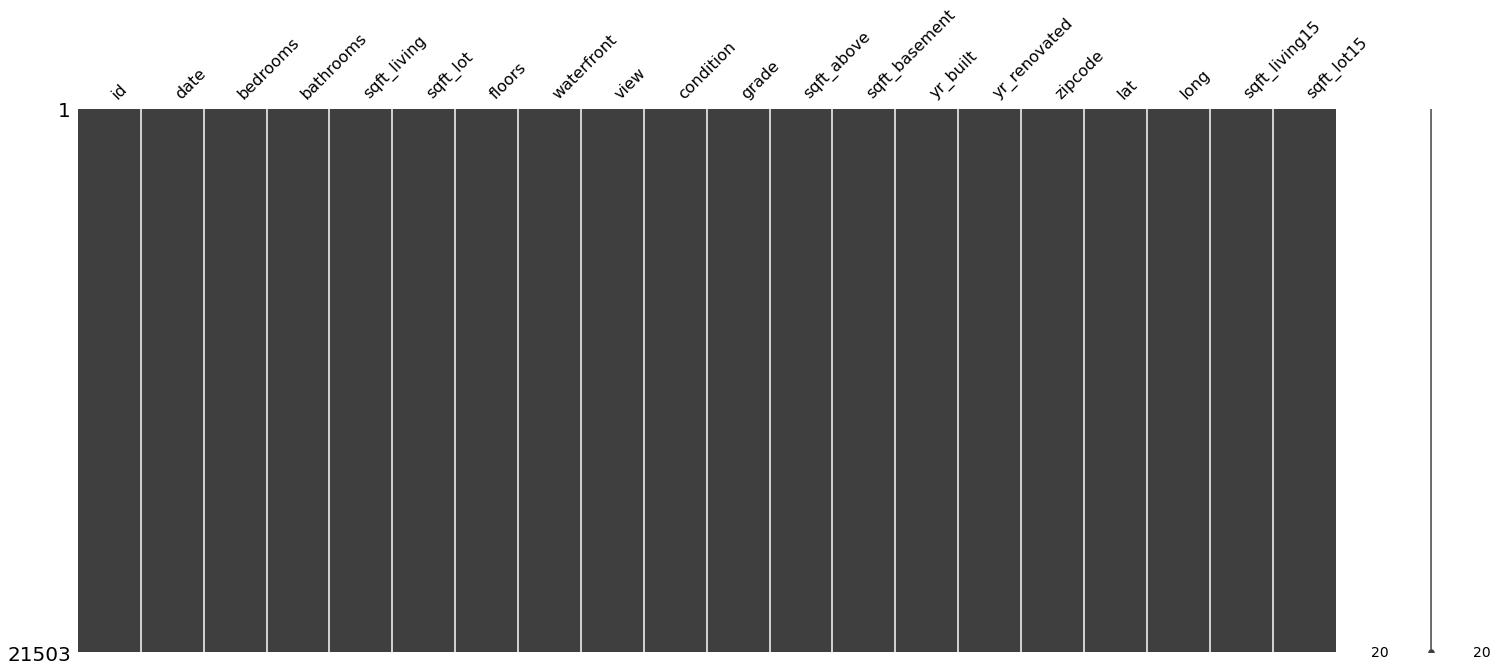

In [8]:
#데이터라는 dataframe을 매트릭스 모양으로 시각화해서 결측치 확인!
#결측치가 있다면 해당 부분이 하얗게 나온다.
msno.matrix(data)

In [9]:
#결측치 개수 출력하기 
#loc 함수 판다스에서 인덱스 기준으로 행데이터 읽는 것
# data 행 안에 있는 데이터를 반복해서 출력
#출력 방식은 딕셔너리에 data의 결측치를 인덱스 기준으로 행데이터를 읽어서 알려줘! 
    
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))
    

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


### 2.데이터 정리하기

In [10]:
# 필요 없는 변수 정리하기( data에서 id 제거, 결과제출을 위해 sub 에 칼럼저장)
sub_id = data['id'][train_len:]
del data['id']

print(data.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [11]:
# data칼럼에서 필요한 부분만 자르기
# data에 있는 data에서 5번째까지만 보여줘!
data['date'] = data['date'].apply(lambda x : str(x[:6]))

data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


* 각 변수들의 분포 확인

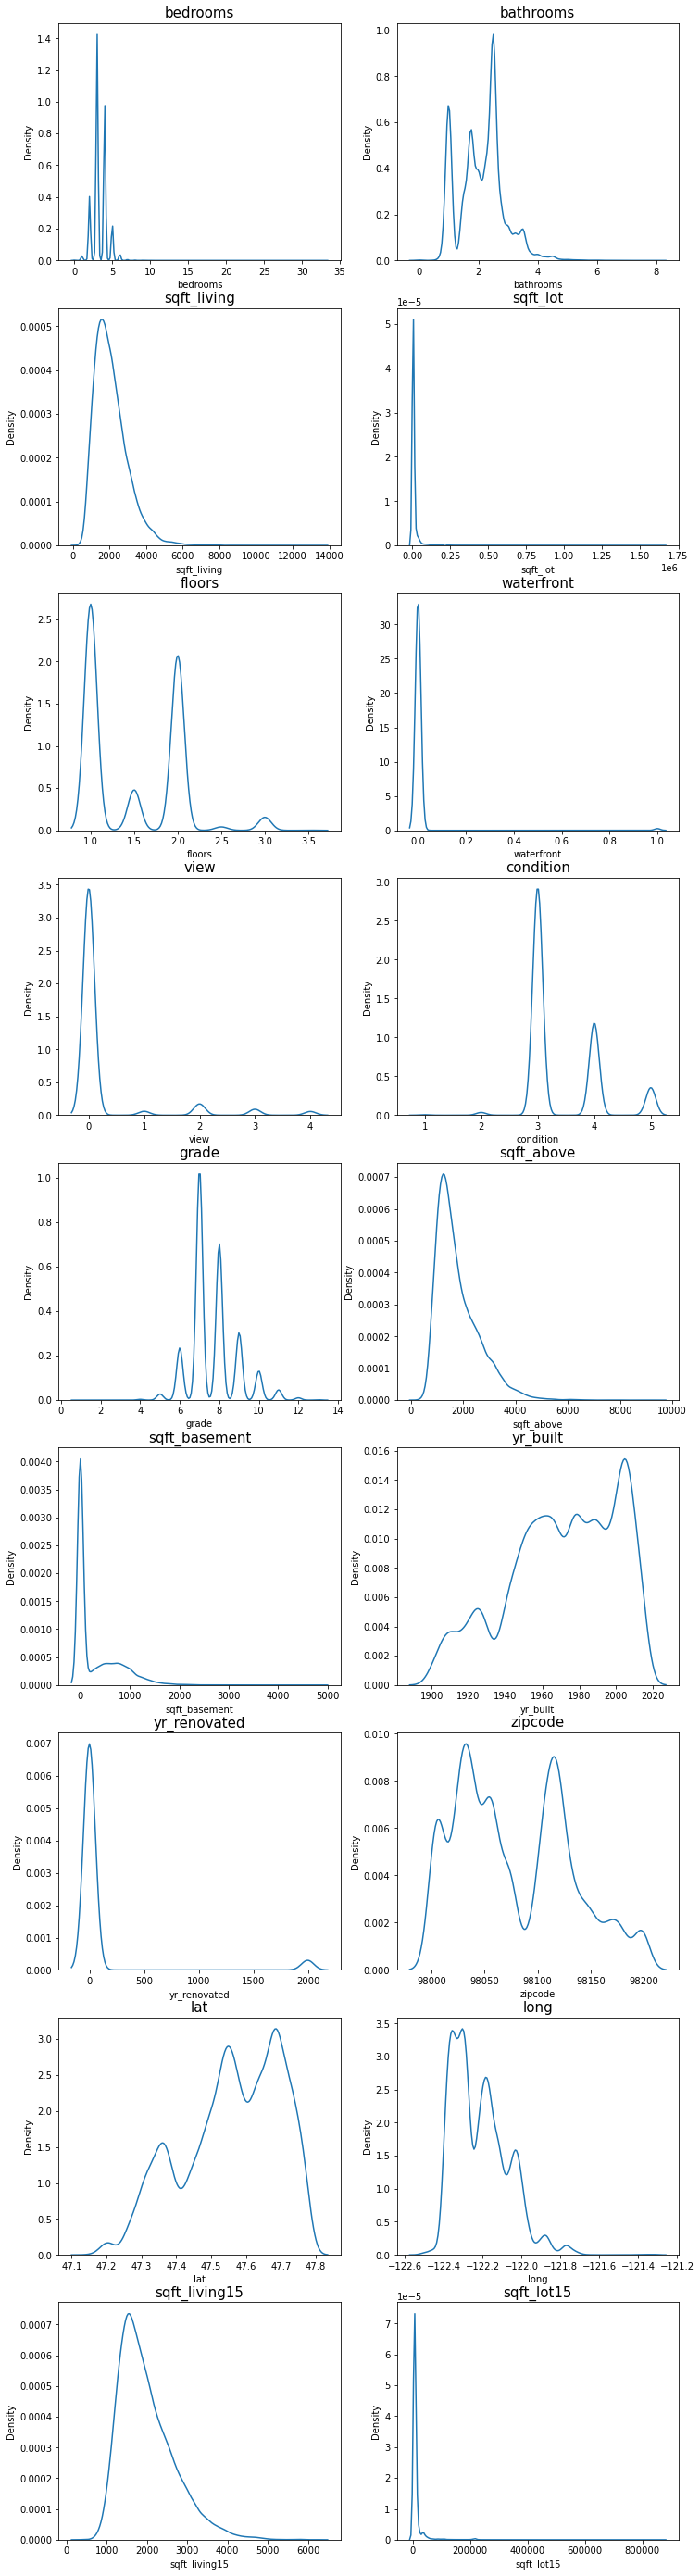

In [12]:
# 전체 데이터의 분포 확인하고 

fig, ax = plt.subplots(9, 2, figsize=(12, 50))  

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
# 
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

*  bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement 변수가 한쪽으로 치우친 경향을 보인다. 
*  한 쪽으로 치우친 분포의 경우에는 로그 변환(log-scaling)을 통해 데이터 분포를 정규분포로 만들어서 치우치지 않게 할 수 있다. 

### 3. 정규화(로그 변환)

In [13]:
# 치우쳐진 변수를 skew 리스트에 담고 로그변환을 한다. 
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

print('얍💢')

얍💢


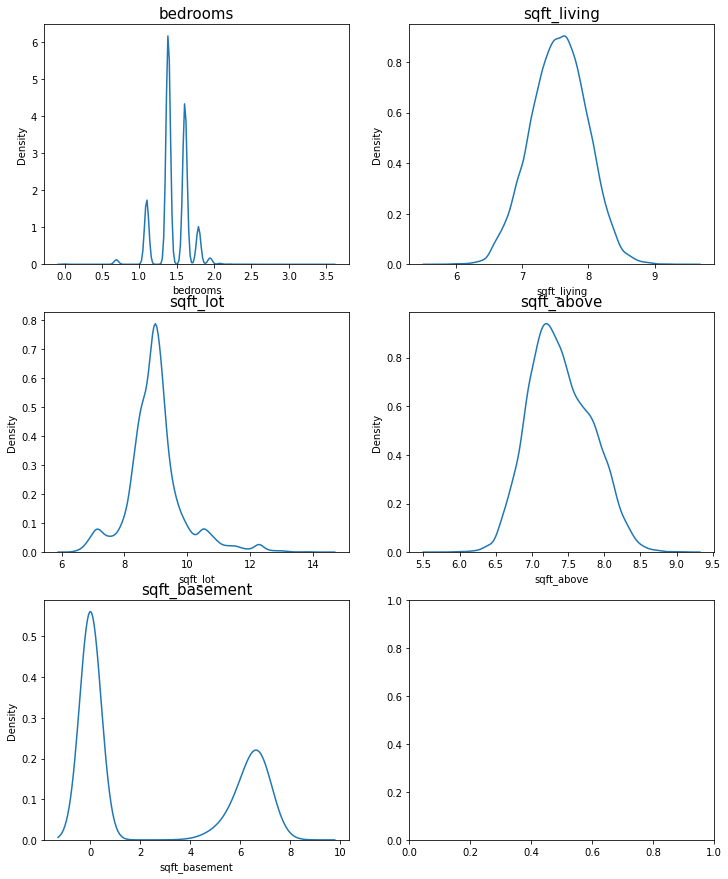

In [14]:
# 정규분포와 비슷하게 바뀌었는지 다시 확인
# count = 0 (이게 뭐지?)

fig, ax = plt.subplots(3, 2, figsize=(12, 15))

count = 0
for row in range(3): #col 2번하고 row 반복
    for col in range(2): #2번 반복 
        if count == 5: # count = 5 면 멈춘다. 
            break
        sns.kdeplot(data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

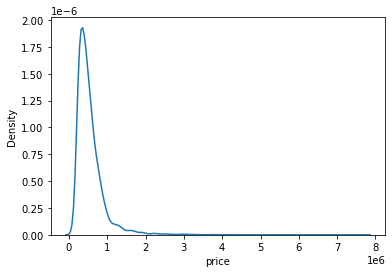

In [15]:
sns.kdeplot(y) # 우리가 가진 집의 가격을 분포
plt.show()

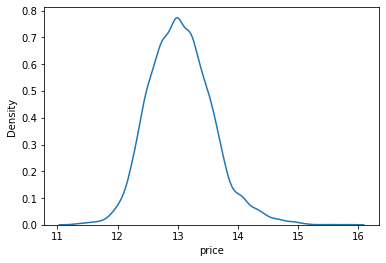

In [16]:
y_log_transformation = np.log1p(y) #로그변환

sns.kdeplot(y_log_transformation)
plt.show()

In [17]:
# 전체 데이터 나누기
# train len 에 학습데이터 개수 저장함
# iloc [열시작: 열끝(열부분), 행시작: 행끝(행부분)]
sub = data.iloc[train_len:, :] 
train_x = data.iloc[:train_len, :] #처음부터 train 행전까지

print(train_x.shape) #학습 x,y
print(sub.shape) 

(15035, 19)
(6468, 19)


# 모델설계

In [18]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

print('얍💢')

얍💢


* 교차검증으로 간단하게 평가해보기
* 참고 사이트: https://tensorflow.blog/%EB%A8%B8%EC%8B%A0-%EB%9F%AC%EB%8B%9D%EC%9D%98-%EB%AA%A8%EB%8D%B8-%ED%8F%89%EA%B0%80%EC%99%80-%EB%AA%A8%EB%8D%B8-%EC%84%A0%ED%83%9D-%EC%95%8C%EA%B3%A0%EB%A6%AC%EC%A6%98-%EC%84%A0%ED%83%9D-3/

In [19]:
#k 겹 교차검증
# 데이터 셋을 k번 반복하는 교차검증, 모델 평가를 위해 한부분은 검증으로 쓰고 나머지를 훈련으로 사용함
#5개의 다른 모델을 만든 후 4개(training)를 학습한 후 나머지 1개(validation)로 평가한다.
#이 과정을 5번(k) 반복해서 성능추정을 구하고 다 합쳐서 산술 평균해서 성능 계산

def get_cv_score(models):
    kfold = KFold(n_splits=5, random_state=2019).get_n_splits(train_x.values) #kfold를 통해서 train_x를 5개로 쪼개기
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], train_x.values, y)), 
                                                  kf=kfold))  
# 5번의 성능평가해서 예측한 값:train_x, 예측해야하는 값(훈련용):y= 두개를 산술평균해서 성능계산        
       
print('얍💢')

얍💢


In [20]:
#cross_val_score() 함수는 1에 가까울 수록 모델이 잘 학습
get_cv_score(models) 

Model GradientBoosting CV score : 0.8597
Model XGBoost CV score : 0.8861
Model LightGBM CV score : 0.8819


# Baseline 모델 예측하기
* AgeragingBlending()- models안에 있는 모델을 모두 x와 y로 학습시킨 뒤 predictions에 그 예측 결괏값을 모아서 평균한 값을 반환합니다.

In [21]:
#여기는 y test가 없다.
def AveragingBlending(models, train_x, y, sub_x): #sub_x - train_x, y 학습 후 예측한 결과값
    for m in models : 
        m['model'].fit(train_x.values, y) #모델 학습
    
    predictions = np.column_stack([ 
        m['model'].predict(sub_x.values) for m in models #위에 모델학습한 값을 모아서 prediction에 담는다.
    ]) 
    return np.mean(predictions, axis=1) #prediction에 있는 평균값을 반환한다

print('얍💢')

얍💢


In [22]:
#예측값 생성
y_pred = AveragingBlending(models, train_x, y, sub) #sub: 제출시 사용할데이터
print(len(y_pred))
y_pred

6468


array([ 529966.66304912,  430726.21272617, 1361676.91242777, ...,
        452081.69137012,  341572.97685942,  421725.1231835 ])

제출하기! 샘플과 같은 형식으로 제출
* 샘플형식은 id price로 구성된 데이터 프레임이다. 

In [23]:
result = pd.DataFrame({
    'id' : sub_id, #초반에 저장한 test용 id
    'price' : y_pred #train으로 훈련을 끝내고 평균값을 반환한 예측값
})

result.head()

,id,price
0,15035,5.299667e+05
1,15036,4.307262e+05
2,15037,1.361677e+06
3,15038,3.338036e+05
4,15039,3.089006e+05


In [24]:
#제출하기!!
my_submission_path = join(data_dir, 'submission.csv')
result.to_csv(my_submission_path, index=False)

print(my_submission_path)

/home/aiffel-dj54/aiffel/aiffel_exp_data/kaggle_kakr_housing/data/submission.csv


# baseline 커널 따라하기는 끝났다. 본격 적용!

## 1. 다시 데이터를 가져오자!

In [24]:
data_dir = os.getenv('HOME')+'/aiffel/aiffel_exp_data/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

print('얍💢')

얍💢


In [25]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


### 1-2) 데이터 정리하기( 문자열-숫자로!, 타겟데이터 y에 넣기)

In [26]:
# date가 문자형이기 때문에 예측을 위한 특성으로 바꿔준다 즉, 숫자로 바꿔준다.
# train에 있는 date에 i 6미만까지 int 형으로 타입을 바꿔줘!
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


### 1-2) 데이터 정리하기( 타겟데이터 y에 넣기)

In [27]:
y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [28]:
del train['id']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [29]:
#여기도 동일하게 date 바꾸고 삭제
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [30]:
y # 타겟 데이터

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

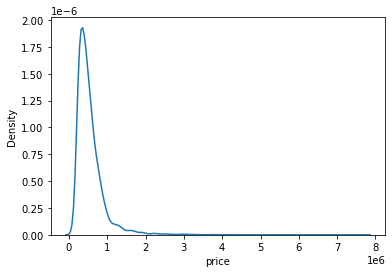

In [31]:
# 가격데이터의 분포 확인하기
sns.kdeplot(y)
plt.show()

In [32]:
# 한쪽으로 치우져처 있다. np.log1p()로 로그 변환을 하고 예측 한 후 다시 되돌린다.
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

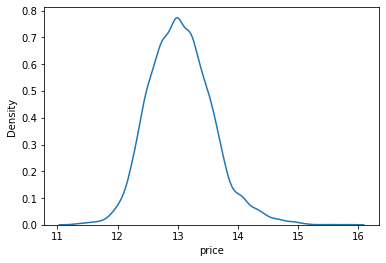

In [33]:
sns.kdeplot(y)
plt.show()

# 2. 모델 튜닝

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error #rmse 점수 계산 # 이 함수의 역할 다시 공부 
from sklearn.model_selection import GridSearchCV

print('얍💢')

얍💢


In [35]:
# RMSE 평가척도 사용하기
# y_test, y_pred - 로그 변환된 값이라 원래 데이터 단위에 맞게 np. expm1해야한다.
# exp로 다시 변환해서 mean sqared 를 계산한 값에 np.squrt 하면 rmse 값 얻을 수 있다. 

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

print('얍💢')

얍💢


In [36]:
#훈련할 모델을 가져오고 리스트에 넣어준다.
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

print('얍💢')

얍💢


In [37]:
random_state=2020        # 고정값을 두어서 학습결과가 일정하도록 설정한다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

model = [lightgbm, xgboost]
print('얍💢')

얍💢


# 모델 학습 및 예측하기

In [38]:
def get_scores(model, train, y):
    df = {}

    for model in model:
        model_name = model.__class__.__name__

        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

    return score_df

In [39]:
get_scores(model, train, y)

,RMSE
LGBMRegressor,111920.367359
XGBRegressor,110318.669566


### Grid Search
사람이 정한 하이퍼 파라미터의 값을 격자로 정해둑 탐색하는 방법
다양하게 실험을 해본 후에 최적의 파라미터를 찾고 데이터를 다시 학습,예측하는 과정을 거친다.

In [49]:
# #파라미터 설정
# param_grid = {
#     'num_leaves':[50,31]
#     'num_estimator':[10, 50], #사용하는 개별모델개수 50-100
#     'max_depth': [1, 1] #나무 깊이
# }                                       
# #     'eta': [0.01],    #훈련량(learning rate: 0.01-0.1
# #     'boosting':['gbdt']

# #grid모델을 초기화하고 train_x와 train_y에 모데 학습 
# grid_model = GridSearchCV(lightgbm, 
#                           param_grid=param_grid,
#                           scoring='neg_mean_squared_error',
#                           cv=5,
#                           verbose=1, 
#                           n_jobs=5)


In [238]:
#파라미터 설정
param_grid = {
    'n_estimators': [335, 330],
    'max_depth': [10, 10],
    'eta': [0.01]
}
#grid모델을 초기화하고 train_x와 train_y에 모데 학습 
grid_model = GridSearchCV(lightgbm, 
                          param_grid=param_grid,
                          scoring='neg_mean_squared_error',
                          cv=5,
                          verbose=1, 
                          n_jobs=5)

In [239]:
grid_model.fit(train, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    2.3s finished


[LightGBM] [Warning] learning_rate is set=0.1, eta=0.01 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2020), n_jobs=5,
             param_grid={'eta': [0.01], 'max_depth': [10, 10],
                         'n_estimators': [335, 330]},
             scoring='neg_mean_squared_error', verbose=1)

In [240]:
grid_model.cv_results_

{'mean_fit_time': array([0.50999227, 0.49184456, 0.51736755, 0.47222724]),
 'std_fit_time': array([0.02281547, 0.01894867, 0.01031923, 0.01661239]),
 'mean_score_time': array([0.04628158, 0.04517088, 0.0477891 , 0.04282608]),
 'std_score_time': array([0.00332174, 0.00186945, 0.00308066, 0.00193645]),
 'param_eta': masked_array(data=[0.01, 0.01, 0.01, 0.01],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[10, 10, 10, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[335, 330, 335, 330],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'eta': 0.01, 'max_depth': 10, 'n_estimators': 335},
  {'eta': 0.01, 'max_depth': 10, 'n_estimators': 330},
  {'eta': 0.01, 'max_depth': 10, 'n_estimators': 335},
  {'eta': 0.01, 'max_depth': 10, 'n_estimat

In [241]:
params = grid_model.cv_results_['params']
params

[{'eta': 0.01, 'max_depth': 10, 'n_estimators': 335},
 {'eta': 0.01, 'max_depth': 10, 'n_estimators': 330},
 {'eta': 0.01, 'max_depth': 10, 'n_estimators': 335},
 {'eta': 0.01, 'max_depth': 10, 'n_estimators': 330}]

In [242]:
score = grid_model.cv_results_['mean_test_score']
score

array([-0.02610936, -0.02610813, -0.02610936, -0.02610813])

In [243]:
results = pd.DataFrame(params)
results['score'] = score

results

,eta,max_depth,n_estimators,score
0,0.01,10,335,-0.026109
1,0.01,10,330,-0.026108
2,0.01,10,335,-0.026109
3,0.01,10,330,-0.026108


In [244]:
results['RMSE'] = np.sqrt(-1 * results['score']) #음수를 양수로 바꾸고 
results = results.rename(columns={'RMSE': 'RMSLE'}) #칼럼 이름을 바꾸고 
results = results.sort_values('RMSLE') #정렬하기 
results

,eta,max_depth,n_estimators,score,RMSLE
1,0.01,10,330,-0.026108,0.161580
3,0.01,10,330,-0.026108,0.161580
0,0.01,10,335,-0.026109,0.161584
2,0.01,10,335,-0.026109,0.161584


In [245]:
model = LGBMRegressor(max_depth=10, n_estimators=330,eta=0.01,n_leaves=40,random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.16509692, 13.07788342, 14.09793662, ..., 13.04889728,
       12.70821344, 12.99945214])

In [246]:
prediction = np.expm1(prediction)
prediction

array([ 521828.88302353,  478246.38491579, 1326342.70323613, ...,
        464582.82383964,  330449.92373629,  442170.07929251])

In [181]:
#제출과정 샘플을 일단 가져오기 
data_dir = os.getenv('HOME')+'/aiffel/aiffel_exp_data/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [214]:
#예측값 넣기 
submission['price'] = prediction
submission.head()

,id,price
0,15035,5.275645e+05
1,15036,4.788479e+05
2,15037,1.326239e+06
3,15038,3.011301e+05
4,15039,3.324835e+05


In [247]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.161580')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/home/aiffel-dj54/aiffel/aiffel_exp_data/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.161580.csv


# 루브릭
프로젝트 루브릭

    1. 데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 캐글 submission까지 전과정이 성공적으로 진행되었는가?
    
    2. 제출된 노트북이 캐글 커널로 사용될 수 있을 만큼 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었는가?
    
    3. 다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110000 이하의 점수를 얻었는가?


# 회고

## [1] 처음에 흐름이 너무 헷갈려서 한참 헤멨다.
baseline과 하이퍼 파라미터 튜닝하는 부분에서 사용하는 방식과 함수가 달라서 너무 헷갈렸다.
그래서 흐름을 자세히 정리하고 진행했다.

### base line 흐름
1. 라이브러리 import
2. 파일 경로 지정(train, test 나눠서 경로지정)
3. 데이터 불러오기(데이터 나눠서 불러오기 , 전처리땐 전체 데이터로 실행)
4. 전처리(결측치 제거, 필요한 데이터만 남기기, 데이터 분포 확인(로그변환하기)
5. 학습을 위해 데이터 나누기
6. 모델설계: 앙상블( avaraging)
- 모델 3개 불러오기 = 변수: models
7. 모델 평가
- ageragingblending() 으로 모델 성능평가하기(cross validation도 연습)
- 모델안에 x,y 학습- prediction에 예측값 모아 평균값 반환
- y_pred (예측값) 생성!
8. 샘플형식으로 제출파일 만들기
- y_pred와 y_test를 비교해야하지만 우리는 y_test가 없다. 제출해서 확인가능
9. submission.csv 파일 저장


### 데이터 튜닝 흐름


13. 데이터 불러오기(생략 가능) / 1-4과정 유사하게 진행
14. 데이터 정리하기(date-int화, y= train[price])

-----------------(여기서부터 다르다)-----------------

15. RMSE 계산 (라이브러리 가져오기,np.expm1으로 원래데이터로 돌리기)
16. 모델 가져오기 
17. 훈련데이터, 검증 데이터로 나누기
18. 모델 학습 - 모델 예측 - 예측결과의 rmse 값 저장 - datafrme 저장
19. 하이퍼파라미터 실험 - 그리드 탐색
20. 그리드모델로 기존 모델 초기화 
21. 그리드에 탐색할 하이퍼파라미터 넣기
22. 모델 준비 
23. 모델 학습
24. 파라미터 값 저장 - 데이터 프레임 생성
25. rmsle 값 계산  (원래 데이터로 rmse 값 계산함 (로그를 취한 상태로 계산함))
26. 실험으로 최적의 파라미터 찾은 후 그걸 모델로 학습
27. np.expm1()으로 원래 스케일로 돌리는것 기억!
28. 샘플형식으로 제출파일 만들기 - csv 파일로 저장 




## [2] [price] 값을 왜 y에 저장하는지 몰라서 초반에 흐름을 읽지 못했다.

y는 y_train 역할을 한다.

x_test : x_train과 y_train에서 학습해서 나온 y_pred가 여기 해당된다.

y_test : baseline엔 이게 없어서 파라미터 수정할때 train에서 split으로 값을 y_test값을 만든다.

## [3] 파라미터 수정
다양하게 파라미터를 수정해봤는데 적용을 잘 못한거 같다. Private score 는 110677점 얻었다...좀 아쉽다 


이번에도 별 2개를 받게 되서 너무 아쉽다...다음엔 3개..꼭 받아야지